<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/meeting1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# ================================
# STEP 1: Install dependencies
# ================================
!pip install chembl_webresource_client rdkit pandas matplotlib seaborn scikit-learn

from chembl_webresource_client.new_client import new_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, DataStructs
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [45]:
# ================================
# STEP 2: Download DRD2 data
# ================================
target_id = "CHEMBL217"  # Dopamine D2 receptor

activities = new_client.activity.filter(target_chembl_id=target_id).only(
    ["molecule_chembl_id", "canonical_smiles", "standard_type",
     "standard_relation", "standard_value", "standard_units", "pchembl_value"]
)

df = pd.DataFrame(activities)
print("Total raw entries:", len(df))


Total raw entries: 24629


In [46]:
df.head()

,canonical_smiles,molecule_chembl_id,pchembl_value,relation,standard_relation,standard_type,standard_units,standard_value,type,units,value
0,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,5.01,=,=,IC50,nM,9800.0,IC50,nM,9800.0
1,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,CHEMBL292943,7.30,=,=,IC50,nM,50.0,IC50,nM,50.0
2,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,CHEMBL156651,10.17,=,=,Ki,nM,0.067,Ki,nM,0.067
3,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,CHEMBL156651,6.72,=,=,Ki,nM,190.0,Ki,nM,190.0
4,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,CHEMBL156651,None,=,=,RH,%,53.0,RH,%,53.0


In [47]:
# ================================
# STEP 3: Clean dataset
# ================================
# Remove duplicate molecules (keep the first occurrence)
df = df.drop_duplicates(subset="canonical_smiles").reset_index(drop=True)

# Drop missing SMILES or pChEMBL
df = df.dropna(subset=["canonical_smiles", "pchembl_value"]).reset_index(drop=True)
df["pchembl_value"] = pd.to_numeric(df["pchembl_value"], errors='coerce')
df = df.dropna(subset=["pchembl_value"]).reset_index(drop=True)

# Optional: keep only common activity types
df = df[df["standard_type"].isin(["IC50", "Ki", "EC50", "Kd"])]
print("Remaining molecules after cleaning:", len(df))


Remaining molecules after cleaning: 7386


In [48]:
df.head()

,canonical_smiles,molecule_chembl_id,pchembl_value,relation,standard_relation,standard_type,standard_units,standard_value,type,units,value
0,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,CHEMBL303519,5.01,=,=,IC50,nM,9800.0,IC50,nM,9800.0
1,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,CHEMBL292943,7.30,=,=,IC50,nM,50.0,IC50,nM,50.0
2,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,CHEMBL156651,10.17,=,=,Ki,nM,0.067,Ki,nM,0.067
3,CC1Cc2cccc3c2N1C(=O)C(N1CCN(Cc2ccc(Cl)cc2)CC1)CC3,CHEMBL349833,6.86,=,=,Ki,nM,139.0,Ki,nM,139.0
4,CC1(C)Cc2cccc3c2N1C(=O)C(N1CCN(Cc2ccc(Cl)cc2)C...,CHEMBL439646,6.70,=,=,Ki,nM,201.0,Ki,nM,201.0


In [49]:
# ================================
# STEP 4: Compute Morgan fingerprints
# ================================
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return fp

df["fingerprint"] = df["canonical_smiles"].apply(smiles_to_fingerprint)
df = df.dropna(subset=["fingerprint"]).reset_index(drop=True)
print("Remaining molecules after fingerprinting:", len(df))

# Convert SMILES to RDKit Mol objects for visualization
df["mol"] = df["canonical_smiles"].apply(lambda x: Chem.MolFromSmiles(x))


Streaming output truncated to the last 5000 lines.
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:35:24] DEPRECATION WARNING: please use MorganGenerator
[12:3

Remaining molecules after fingerprinting: 7386


In [50]:
# ================================
# STEP 5: Sample pairs for similarity analysis
# ================================
# Sample pairs where i != j
pairs = []
n_samples = 5000

while len(pairs) < n_samples:
    i, j = random.sample(range(len(df)), 2)
    if i != j:  # ensure different molecules
        fp1, fp2 = df.loc[i, "fingerprint"], df.loc[j, "fingerprint"]
        sim = DataStructs.TanimotoSimilarity(fp1, fp2)
        act_diff = abs(df.loc[i, "pchembl_value"] - df.loc[j, "pchembl_value"])
        pairs.append((i, j, sim, act_diff))

pairs_df = pd.DataFrame(pairs, columns=["i", "j", "similarity", "activity_difference"])

pairs_df.head()

,i,j,similarity,activity_difference
0,6054,5324,0.146789,0.60
1,2185,4036,0.139535,0.12
2,6153,3640,0.121951,1.89
3,3817,2979,0.086957,0.90
4,7120,431,0.076923,0.89


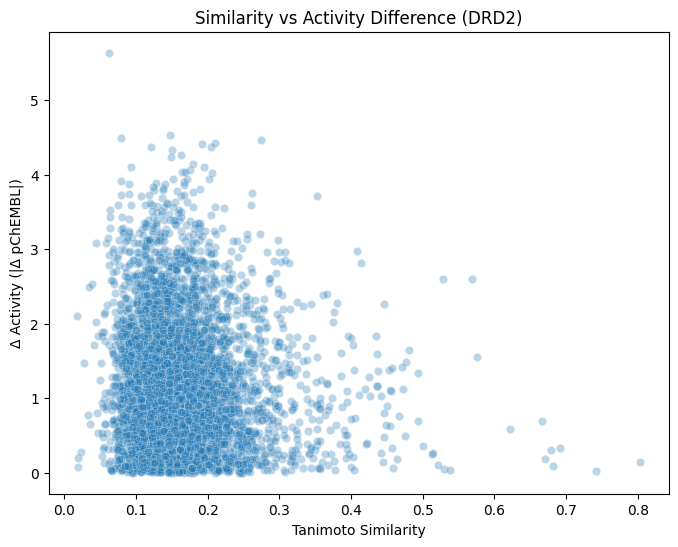

In [51]:
# ================================
# STEP 6: Scatter plot - similarity vs activity difference
# ================================
plt.figure(figsize=(8,6))
sns.scatterplot(data=pairs_df, x="similarity", y="activity_difference", alpha=0.3)
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Δ Activity (|Δ pChEMBL|)")
plt.title("Similarity vs Activity Difference (DRD2)")
plt.show()


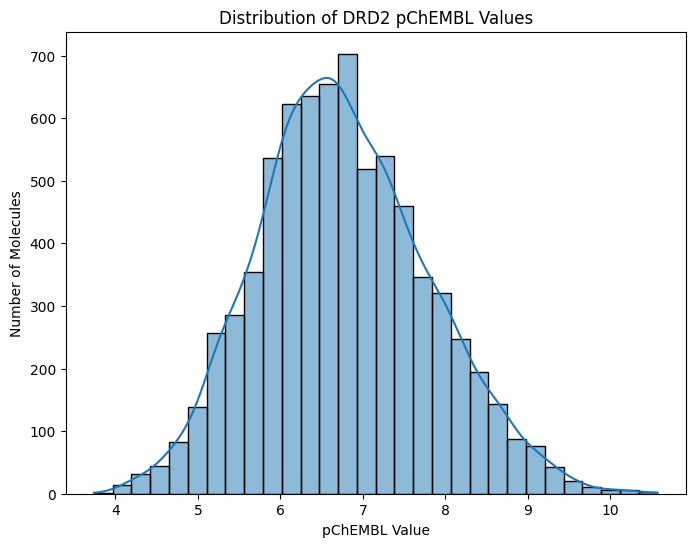

In [52]:
# ================================
# STEP 7: Histogram of pChEMBL values
# ================================
plt.figure(figsize=(8,6))
sns.histplot(df["pchembl_value"], bins=30, kde=True)
plt.xlabel("pChEMBL Value")
plt.ylabel("Number of Molecules")
plt.title("Distribution of DRD2 pChEMBL Values")
plt.show()


In [53]:
# ================================
# STEP 8: Correlation analysis
# ================================
corr = pairs_df["similarity"].corr(pairs_df["activity_difference"])
print(f"Correlation between similarity and activity difference: {corr:.3f}")


Correlation between similarity and activity difference: -0.065


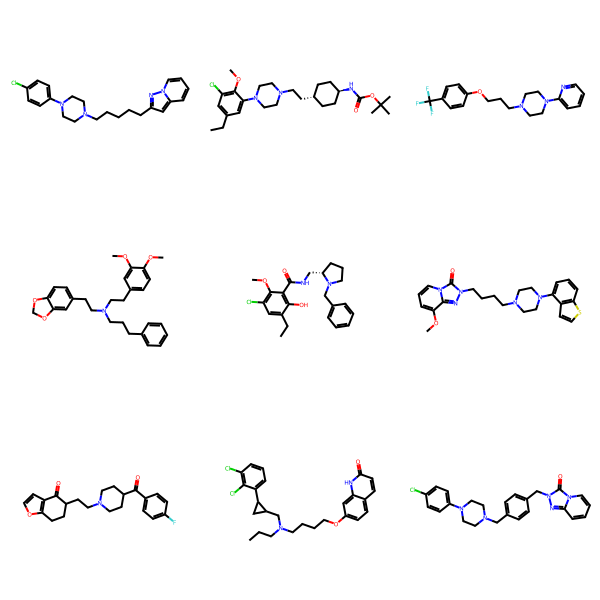

In [54]:

# ================================
# STEP 9: Show 2D images of random molecules
# ================================
sample_mols = df.sample(9)["mol"].tolist()
img = Draw.MolsToGridImage(sample_mols, molsPerRow=3, subImgSize=(200,200))
display(img)



Most similar pair - Tanimoto: 0.804, ΔpChEMBL: 0.14


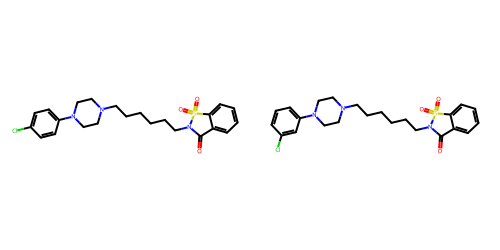

In [55]:
# ================================
# STEP 10: Most similar pair
# ================================
most_sim = pairs_df.loc[pairs_df["similarity"].idxmax()]
mol1 = df.loc[most_sim["i"], "mol"]
mol2 = df.loc[most_sim["j"], "mol"]
sim_val = most_sim["similarity"]
act_diff_val = most_sim["activity_difference"]

print(f"Most similar pair - Tanimoto: {sim_val:.3f}, ΔpChEMBL: {act_diff_val:.2f}")
display(Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(250,250)))


Least similar pair - Tanimoto: 0.018, ΔpChEMBL: 2.10


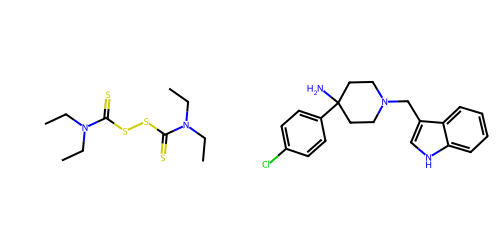

In [56]:
# ================================
# STEP 11: Least similar pair
# ================================
least_sim = pairs_df.loc[pairs_df["similarity"].idxmin()]
mol1 = df.loc[least_sim["i"], "mol"]
mol2 = df.loc[least_sim["j"], "mol"]
sim_val = least_sim["similarity"]
act_diff_val = least_sim["activity_difference"]

print(f"Least similar pair - Tanimoto: {sim_val:.3f}, ΔpChEMBL: {act_diff_val:.2f}")
display(Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(250,250)))


In [57]:


# ================================
# STEP 12: Save datasets for future use
# ================================
df.to_csv("DRD2_activities_fingerprints.csv", index=False)
pairs_df.to_csv("DRD2_similarity_activity_pairs.csv", index=False)
print("Data saved to CSV files.")


Data saved to CSV files.


/tmp/ipython-input-1496934974.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = pairs_df.groupby('sim_bin')['activity_difference'].agg(['mean','std','count']).reset_index()


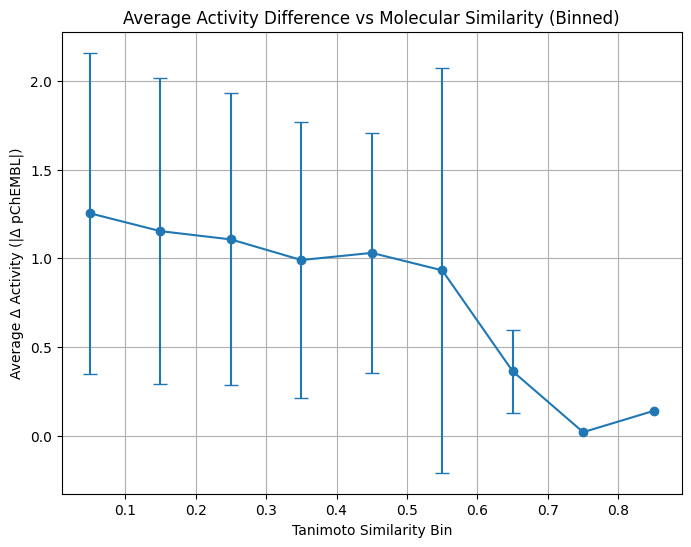

In [58]:
# ================================
# STEP 13: Binned plot - average activity difference vs similarity bins
# ================================
# Define bins
bins = np.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0
pairs_df['sim_bin'] = pd.cut(pairs_df['similarity'], bins)

# Compute mean and std of activity differences per bin
binned_stats = pairs_df.groupby('sim_bin')['activity_difference'].agg(['mean','std','count']).reset_index()
binned_stats = binned_stats[binned_stats['count']>0]  # remove empty bins

# Plot
plt.figure(figsize=(8,6))
plt.errorbar(
    x=[interval.mid for interval in binned_stats['sim_bin']],
    y=binned_stats['mean'],
    yerr=binned_stats['std'],
    fmt='o-', capsize=5
)
plt.xlabel("Tanimoto Similarity Bin")
plt.ylabel("Average Δ Activity (|Δ pChEMBL|)")
plt.title("Average Activity Difference vs Molecular Similarity (Binned)")
plt.grid(True)
plt.show()
